<a href="https://colab.research.google.com/github/joyalrj22/KAPAY/blob/master/coursework_pegasusII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q torch torchvision livelossplot

**Main imports**

In [0]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [0]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=True, batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=False, batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))
print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**Useful Functions for Network**

In [0]:
# Linearly interpolate two tensors
interpolate = lambda start, end, weights: start+weights*(end-start)

# Loss Function (L2)
loss_L2 = lambda x: torch.mean(x**2)

activation = nn.ReLU

def shuffleEncodings(encodings):
  # Split encoding into 4 then reorder according to random permutation of 1-4
  splitEncodings = encodings.split(encodings.shape[0]//4)
  shuffled = tuple(np.random.permutation(splitEncodings))
  return torch.cat(shuffled)


**View some of the test dataset**

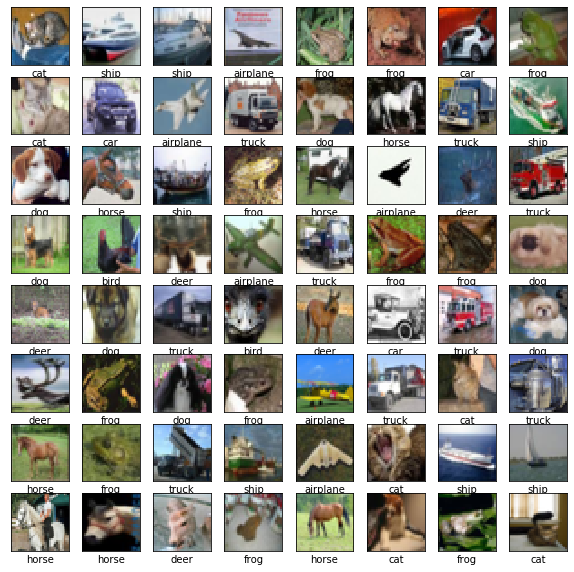

In [0]:
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[test_loader.dataset[i][1]])

**Define an ACAI model**

In [0]:
# define the model
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        layers = nn.ModuleList()
        ##################################################
        #                    ENCODER                     #
        ##################################################
       
        # 19
        layers.extend([
                       nn.Conv2d(3, 9, 1, padding=1),
                       
                       nn.Conv2d(9, 18, 3, padding=1),
                       nn.ReLU(),
                       nn.Conv2d(18, 18, 3, padding=1),
                       #nn.ReLU(),
                       nn.BatchNorm2d(18),
                       nn.AvgPool2d(2),

                       nn.Conv2d(18, 36, 3, padding=1),
                       nn.ReLU(),
                       nn.Conv2d(36, 36, 3, padding=1),
                       #nn.ReLU(),
                       nn.BatchNorm2d(36),
                       nn.AvgPool2d(2),

                       nn.Conv2d(36, 72, 3, padding=1),
                       nn.ReLU(),
                       nn.Conv2d(72, 72, 3, padding=1),
                      # nn.ReLU(),
                       nn.BatchNorm2d(72),
                       nn.AvgPool2d(2),

                       nn.Conv2d(72, 144, 3, padding=1),
                       nn.ReLU(),
                       nn.Conv2d(144, 2, 3, padding=1)   
        ])
        

        ##################################################
        #                    DECODER                     #
        ##################################################
        # 18
        layers.extend([
                       nn.Conv2d(2, 72, 3, padding=1),
                       nn.ReLU(),
                       nn.Conv2d(72, 72, 3, padding=1),
                       #nn.ReLU(),
                       nn.BatchNorm2d(72),
                       nn.Upsample(scale_factor=2), 

                       nn.Conv2d(72, 36, 3, padding=1),
                       nn.ReLU(),
                       nn.Conv2d(36, 36, 3, padding=1),
                       #nn.ReLU(),
                       nn.BatchNorm2d(36),
                       nn.Upsample(scale_factor=2),

                       nn.Conv2d(36, 18, 3, padding=1),
                       nn.ReLU(),
                       nn.Conv2d(18, 18, 3, padding=1),
                       #nn.ReLU(),
                       nn.BatchNorm2d(18),
                       nn.Upsample(scale_factor=2),  

                       nn.Conv2d(18, 9, 3, padding=1),
                       nn.ReLU(),
                       nn.Conv2d(9, 3, 3, padding=1)
        ])

        self.layers = layers

    def forward(self, x):      
        z = self.encode(x)
        x = self.decode(z)
        return x

    # encode (flatten as linear, then run first half of network)
    def encode(self, x):
        for i in range(19):
            x = self.layers[i](x)
        return x

    # decode (run second half of network then unflatten)
    def decode(self, x):
        for i in range(19, 37):
            x = self.layers[i](x)
        x = x.view(x.size(0), 3, 32, 32)
        return x

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    layers = nn.ModuleList()
    
    # 18
    layers.extend([
                    nn.Conv2d(3, 9, 1, padding=1),
                    
                    nn.Conv2d(9, 18, 3, padding=1),
                    nn.LeakyReLU(),
                    nn.Conv2d(18, 18, 3, padding=1),
                    nn.BatchNorm2d(18),
                    nn.AvgPool2d(2),

                    nn.Conv2d(18, 36, 3, padding=1),
                    nn.LeakyReLU(),
                    nn.Conv2d(36, 36, 3, padding=1),
                    nn.BatchNorm2d(36),
                    nn.AvgPool2d(2),

                    nn.Conv2d(36, 72, 3, padding=1),
                    nn.LeakyReLU(),
                    nn.Conv2d(72, 72, 3, padding=1),
                    nn.BatchNorm2d(72),
                    nn.AvgPool2d(2),

                    nn.Conv2d(72, 144, 3, padding=1),
                    nn.LeakyReLU(),
                    nn.Conv2d(144, 2, 3, padding=1)   
    ])

    self.layers = layers

  def forward(self, x):
    for i in range(18):
        x = self.layers[i](x)

    x = x.reshape(x.shape[0], -1)
    x = torch.mean(x, -1)
    return x

AE = AutoEncoder().to(device)
D = Discriminator().to(device)
print(f'> Number of network parameters {len(torch.nn.utils.parameters_to_vector(AE.parameters()))}')

# initialise the optimise
encoder_opt = torch.optim.Adam(AE.parameters(),lr=0.00002)
discriminator_opt = torch.optim.Adam(D.parameters(),lr=0.00001)

epoch = 0
liveplot = PlotLosses()

> Number of network parameters 282353


**Train on training dataset**

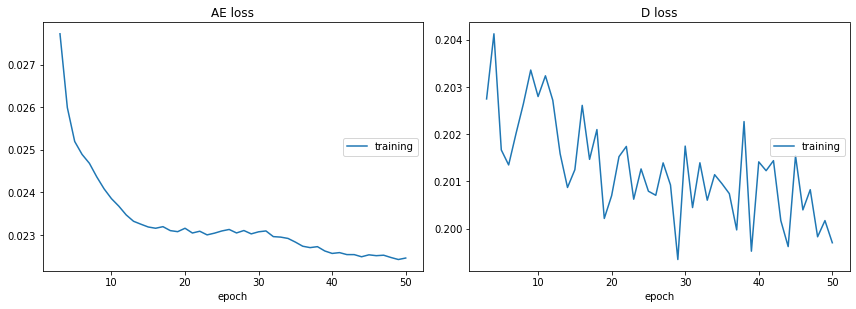

AE loss:
training   (min:    0.022, max:    0.090, cur:    0.022)

D loss:
training   (min:    0.195, max:    0.204, cur:    0.200)


In [0]:
import sys

reg = 0.3
while (epoch<50):
    
    # arrays for metrics
    logs = {}
    train_loss_arr = np.zeros(0)
    discrim_loss_arr = np.zeros(0)
    # iterate over some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        # Train decoded image to be similar to original image
        encoded = AE.encode(x)
        decoded = AE.decode(encoded)
        inOutInterpolated = torch.lerp(decoded, x, reg)
        discriminated = D(inOutInterpolated)

        interpolationWeights = torch.rand(64, 1, 1, 1).to(device)
        encodings_mixed = shuffleEncodings(encoded)
        interpolatedEncodings = interpolate(encoded, encodings_mixed, interpolationWeights)
        decodedInterpolations = AE.decode(interpolatedEncodings)
        discriminatedInterpolations = D(decodedInterpolations)

        encoder_opt.zero_grad()
        discriminator_opt.zero_grad()

        autoencoder_loss = ((decoded-x)**2).mean() + torch.mean(discriminatedInterpolations**2)*0.1
        discriminator_loss = ((discriminatedInterpolations-interpolationWeights)**2).mean() + torch.mean(discriminated**2)


        autoencoder_loss.backward(retain_graph=True)
        encoder_opt.step()

        discriminator_loss.backward()
        discriminator_opt.step()        

        train_loss_arr = np.append(train_loss_arr, autoencoder_loss.item())
        discrim_loss_arr = np.append(discrim_loss_arr, discriminator_loss.item())

    # plot the loss
    liveplot.update({
        'AE loss': train_loss_arr.mean(),
        'D loss': discrim_loss_arr.mean()
    })
    liveplot.draw()

    epoch = epoch+1

**Generate a Pegasus by interpolating between the latent space encodings of a horse and a bird**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


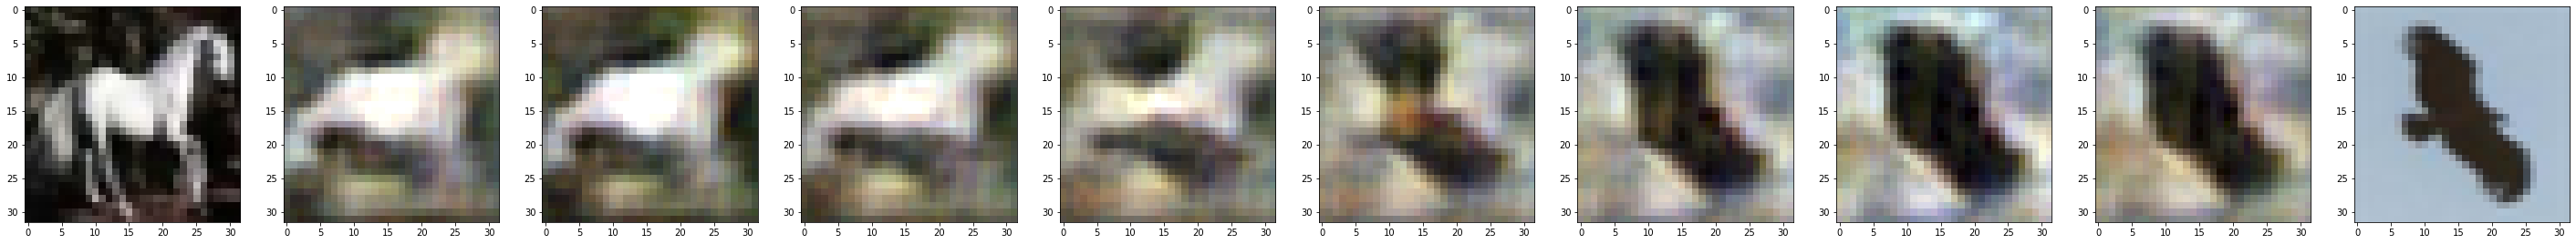

In [0]:
horse = test_loader.dataset[13][0].to(device)  # horse
bird = test_loader.dataset[160][0].to(device) # bird
encoded_horse = AE.encode(horse.unsqueeze(0)).data.cpu().numpy()
encoded_bird = AE.encode(bird.unsqueeze(0)).data.cpu().numpy()

pegasus = [encoded_horse*(1-t) + encoded_bird*t for t in np.linspace(0,1,6)]
pegasus = np.vstack(pegasus)
pegasus = AE.decode(torch.FloatTensor(pegasus).to(device)).squeeze(0)


horse1 = AE.decode(torch.FloatTensor(encoded_horse).to(device)).squeeze(0)
bird1 = AE.decode(torch.FloatTensor(encoded_bird).to(device)).squeeze(0)

#plt.grid(False)
f, axarr = plt.subplots(1, 10, figsize=(50,50))

axarr[0].imshow(horse.cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
axarr[1].imshow(horse1.cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
axarr[2].imshow(pegasus[0].cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
axarr[3].imshow(pegasus[1].cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
axarr[4].imshow(pegasus[2].cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
axarr[5].imshow(pegasus[3].cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
axarr[6].imshow(pegasus[4].cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
axarr[7].imshow(pegasus[5].cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
axarr[8].imshow(bird1.cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
axarr[9].imshow(bird.cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

#plt.imshow((pegasus[0].cpu().data.permute(0,2,1).contiguous().permute(2,1,0) * 255).numpy().astype(np.uint8), cmap=plt.cm.binary)
#for i in range(len(test_loader.dataset.test_labels)):
#  print(class_names[test_loader.dataset.test_labels[i]] + '\t idx: ' + str(i))

**Sample a batch from the generative model to show the output diversity**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

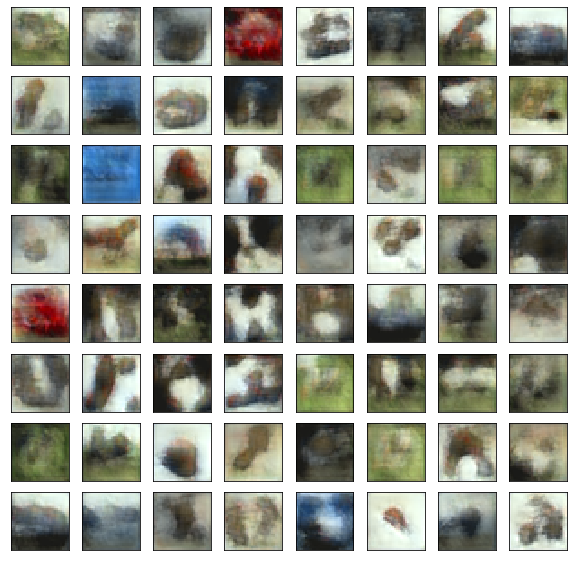

In [0]:
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
p = AE(x)

plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(p[i].cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)